# Vector Auto-Regression Moving Average

Recall the ystems of equations for a 2-dimensional VAR(1) model:

$y_1 = c_1 + \phi_{11,1} y_{1,t-1} + \phi_{12,1} y_{2,t-1} + \epsilon_{1,t}$\
$y_2 = c_1 + \phi_{21,1} y_{1,t-1} + \phi_{22,1} y_{2,t-1} + \epsilon_{2,t}$

Also, recall the system of equaltion for the ARMA model:
    
$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} +\; ... + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}$\

We can cerate an analogous function using VARMA to consider 2 related time series (for p=1 and q=1):
    
$y_{1,t} = c + \phi_{11,1} y_{t-1} + \phi_{12,1} y_{2,t-1} + \epsilon_{1,t} + \theta_{11,1} \epsilon_{1,t-1} + \theta_{12,1} \epsilon_{2,t-1}$\
$y_{2,t} = c + \phi_{21,1} y_{t-1} + \phi_{22,1} y_{2,t-1} + \epsilon_{2,t} + \theta_{21,1} \epsilon_{1,t-1} + \theta_{22,1} \epsilon_{2,t-1}$

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('../Data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('../Data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

## Inspect the data

In [2]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [3]:
df = df.dropna()
df.shape

(252, 2)

### Plot the source data

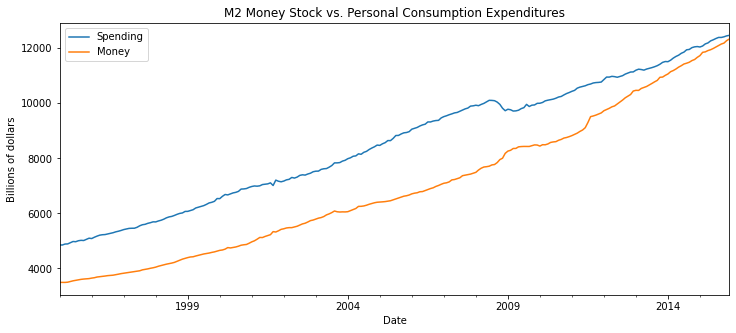

In [4]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

## Test for stationarity, perform any necessary transformations
In the previous section we applied the augmented Dickey-Fuller test and found that a second-order difference achieved stationarity. In this section we'll perform the <strong>auto_arima</strong> prediction to identify optimal $p$ and $q$ orders.

In [6]:
# INCLUDED HERE IF YOU CHOOSE TO USE IT
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

<div class="alert alert-info"><strong>NOTE: </strong> When performing the auto_arima function we're likely to see a <tt><font color=black>ConvergenceWarning: Maximum Likelihood optimization failed to converge.</font></tt> This is not unusual in models which have to estimate a large number of parameters. However, we can override the maximum iterations default of 50, and pass an arbitrarily large number with <tt>maxiter=1000</tt>. We'll see this come up again when we fit our model.</div>  

In [7]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

It looks like a VARMA(1,2) model is recommended. Note that the $d$ term (2 for Money, 1 for Spending) is about to be addressed by transforming the data to make it stationary. As before we'll apply a second order difference.

In [9]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [10]:
len(df_transformed)

250

## Train/test/split
It is useful to define a number of observations variable for our test set. For this analysis, let's use 12 months.

In [11]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [12]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


## Fit the VARMA(1,2) Model
This may take awhile.

In [29]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.059
,+ intercept,AIC,4606.118
Date:,"Wed, 16 Dec 2020",BIC,4665.146
Time:,17:14:13,HQIC,4629.907
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.52, 0.00",Jarque-Bera (JB):,"556.11, 124.95"
Prob(Q):,"0.47, 0.96",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.62, 2.88",Skew:,"1.34, -0.34"


## Predict the next 12 values
Unlike the VAR model we used in the previous section, the VARMAX <tt>.forecast()</tt> function won't require that we pass in a number of previous observations, and it will provide an extended DateTime index.

In [30]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.620920,37.530609
2015-02-01,-11.185250,-5.091487
2015-03-01,1.543678,-0.079048
2015-04-01,-1.696859,-0.453850
2015-05-01,1.097629,0.281870
2015-06-01,-0.410766,-0.059515
2015-07-01,0.525231,0.164355
2015-08-01,-0.029285,0.033986
2015-09-01,0.304166,0.112826
2015-10-01,0.104620,0.065732


## Invert the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [31]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [32]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

## Plot the results

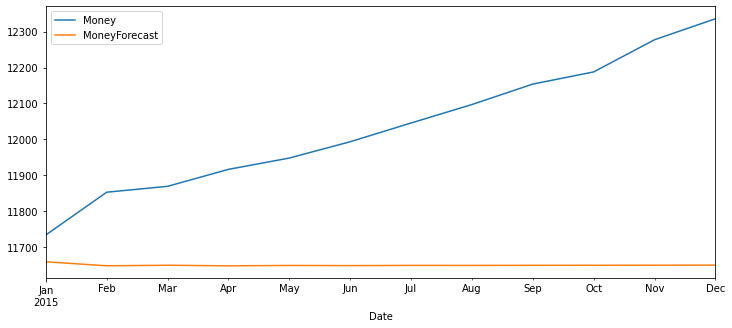

In [33]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

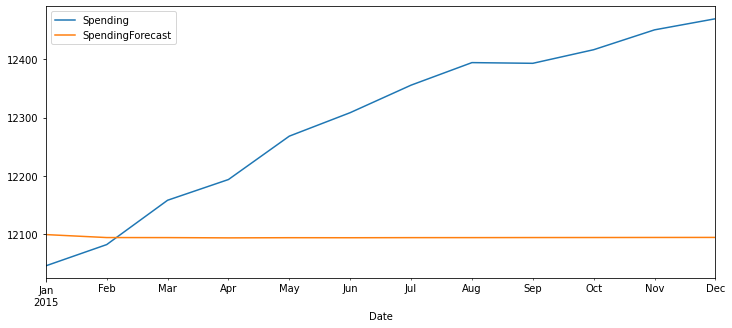

In [34]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

### Evaluate the model

&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>
where $T$ is the last observation period and $l$ is the lag.

In [35]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')

Money VARMA(1,2) RMSE: 423.105


In [36]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')

Spending VARMA(1,2) RMSE: 243.274


Clearly these results are less accurate than our earlier VAR(5) model. Still, this tells us something!
## Let's compare these results to individual ARMA(1,2) models

In [38]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

## Money

In [39]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.214
Date:                Wed, 16 Dec 2020   AIC                           2245.421
Time:                        17:15:43   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.217      0.223      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.573      0.116      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.023      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [40]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [41]:
z1

,Money
2015-01-01,-14.499560
2015-02-01,-10.947289
2015-03-01,4.152707
2015-04-01,-1.235780
2015-05-01,0.687121
2015-06-01,0.000927
2015-07-01,0.245798
2015-08-01,0.158415
2015-09-01,0.189598
2015-10-01,0.178470


### Invert the Transformation, Evaluate the Forecast

In [43]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [44]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.499560,64.100440,11734.200440
2015-02-01,-10.947289,53.153151,11787.353591
2015-03-01,4.152707,57.305858,11844.659449
2015-04-01,-1.235780,56.070079,11900.729528
2015-05-01,0.687121,56.757199,11957.486727
2015-06-01,0.000927,56.758126,12014.244854
2015-07-01,0.245798,57.003924,12071.248778
2015-08-01,0.158415,57.162339,12128.411117
2015-09-01,0.189598,57.351937,12185.763053
2015-10-01,0.178470,57.530407,12243.293460


### Plot the results

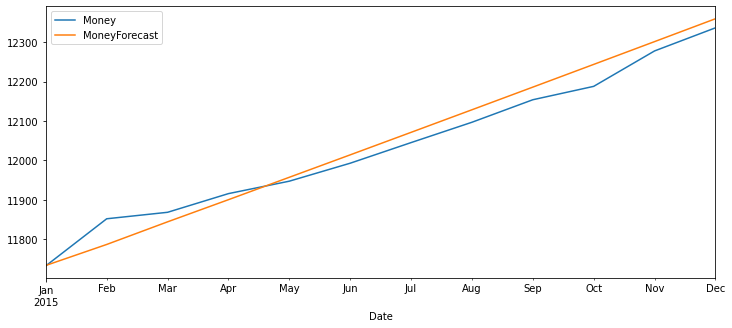

In [52]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
z1['MoneyForecast'].plot(legend=True);

### Evaluate the model

In [45]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 423.105
Money  ARMA(1,2) RMSE: 32.232


## Personal Spending

In [46]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Wed, 16 Dec 2020   AIC                           2374.823
Time:                        17:17:36   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.726      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.505      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.216      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.659      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9387           +0.0000j            2.9387            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1438           +0.0000j            4.1438            0.5000
-----------------------------------------------------------------------------
"""

In [47]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555841
2015-02-01,-3.338260
2015-03-01,1.250714
2015-04-01,-0.310837
2015-05-01,0.220532
2015-06-01,0.039716
2015-07-01,0.101245
2015-08-01,0.080308
2015-09-01,0.087432
2015-10-01,0.085008


### Invert the Transformation, Evaluate the Forecast

In [49]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [50]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555841,44.155841,12106.155841
2015-02-01,-3.338260,40.817580,12146.973421
2015-03-01,1.250714,42.068294,12189.041715
2015-04-01,-0.310837,41.757457,12230.799172
2015-05-01,0.220532,41.977989,12272.777161
2015-06-01,0.039716,42.017705,12314.794866
2015-07-01,0.101245,42.118950,12356.913816
2015-08-01,0.080308,42.199258,12399.113074
2015-09-01,0.087432,42.286690,12441.399763
2015-10-01,0.085008,42.371698,12483.771461


### Plot the results

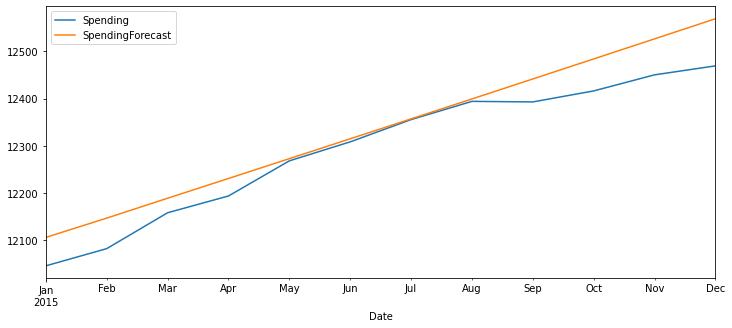

In [53]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
z2['SpendingForecast'].plot(legend=True);

### Evaluate the model

In [51]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 243.274
Spending  ARMA(1,2) RMSE: 52.334
